# Interpolation, imputation and blending of atmosphere models

Atmosphere grids provide emergent specific intensity of light as a function of atmospheric parameters (Teff, logg, heavy metal abundance, micro- and macro-turbulence, rotational and revolutional radial velocity, ...). These are computed by the model atmosphere codes in (usually) regularly spaced grids of parameters. While some combinations of parameters are not physical, there can be combinations of parameters that *are* physical but that model atmospheres fail to converge. As computing atmospheric models is outside of PHOEBE's realm, we rely on other works to provide the atmosphere grids for us. When these grids feature combinations of parameters that are physical but that do not come with a corresponding emergent specific intensity, we need to *impute* them: replace the non-existent values with their *estimates* from values that are available.

### General principles of interpolation and imputation

Imputation of missing values has a long history in data science and [many approaches have been proposed](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779), either general or specific to the problem at hand. In our case we devised an imputation method that closely follows the overall assumptions in treating model atmosphere grids:

* the shape of the parameter space is locally linear to the extent that linear interpolation is adequate within the model uncertainties;
* the definition range of atmosphere grids should not be extended past the original parameter spans; and
* off-grid intensities should be smoothly "ramped" to (or blended with) a wider grid or a theoretical model, such as the blackbody atmosphere.


In [1]:
import numpy as np
import phoebe
import matplotlib.pyplot as plt
from scipy.special import binom as binomial
from scipy import spatial

The first component we need is an $N$-dimensional interpolation/extrapolation function. Given a sequence of axes (a 3D example is depicted below), interpolation successively reduces the number of dimensions in which it interpolates. It starts with the corners of the $N$-dimensional hypercube (solid circles) to obtain interpolated values (open squares) in the $(N-1)$-dimensional hyperplane while keeping the *last* axis constant ($z$-axis in the figure below). It then removes the last axis and forms a $(N-1)$-dimensional hypercube from the interpolated vertices. The process is then restarted and continued until we obtain the interpolated value in the point of interest (open circle).



Note that the choice of interpolating along the *last* axis is both arbitrary (we could just as easily choose any other axis to start with) and general (we could pivot the axes if another interpolation sequence is desired). For as long as the parameter space is sufficiently linear, the choice of axis sequence is not too important, but any local non-linearity will cause the sequence to matter.

The algorithm takes a vector (or an array of vectors) of interest `x` (open circle), the initial dimension of the interpolation space `N`, an $N$-dimensional vector of lower vertex axis values `lo`, an $N$-dimensional vector of upper vertex axis values `hi`, and an array of $2^N$ function values `fv` sorted by vertices in the following sequence:

$$ fv = \left[
\begin{matrix}
f(x_{1,\mathrm{lo}}, x_{2,\mathrm{lo}}, \dots, x_{N,\mathrm{lo}}) \\
f(x_{1,\mathrm{hi}}, x_{2,\mathrm{lo}}, \dots, x_{N,\mathrm{lo}}) \\
f(x_{1,\mathrm{lo}}, x_{2,\mathrm{hi}}, \dots, x_{N,\mathrm{lo}}) \\
f(x_{1,\mathrm{hi}}, x_{2,\mathrm{hi}}, \dots, x_{N,\mathrm{lo}}) \\
\vdots \\
f(x_{1,\mathrm{hi}}, x_{2,\mathrm{hi}}, \dots, x_{N,\mathrm{hi}}) \\
\end{matrix}
\right] $$

where $x_k$ are the axis values for the $k$-th axis. Interpolation proceeds from the last axis to the first, and array `fv` is modified in the process, so we need to pass a copy of the subgrid instead of the actual grid.

In [2]:
def ndpolate(x, lo, hi, fv, copy_data=False):
    """
    @x: vector of interest
    @lo: N-dimensional vector of lower knot values
    @hi: N-dimensional vector of upper knot values
    @fv: (2^N)-dimensional vector of function values at knots
    """

    N = len(lo)
    powers = [2**k for k in range(N+1)]

    n = np.empty((powers[N], N))

    if copy_data:
        fv = fv.copy()
        
#     lfv = fv.copy() if copy_data else fv
    
    for i in range(N):
        for j in range(powers[N]):
            n[j,i] = lo[i] + (int(j/powers[i]) % 2) * (hi[i]-lo[i])
    
    for i in range(N):
        for j in range(powers[N-i-1]):
            fv[j] += (x[N-i-1]-n[j,N-i-1])/(n[j+powers[N-i-1],N-i-1]-n[j,N-i-1])*(fv[j+powers[N-i-1]]-fv[j])

    return fv[0]

Consider an N-dimensional hypercube spun by the atmospheric parameters (a 3D example is depicted in the figure below). Let the central point be the imputation vertex (i.e., a NaN value). Other vertices can either either have associated values or NaNs. In general, there are $3^N-1$ bounding vertices (so 26 in 3D).



If all bounding vertex values are defined, there are $N \choose D$ combinations to interpolate in $D$-dimensional subspace. In 3D, there is 1 combination in 3D, 3 combinations in 2D, and 3 combinations in 1D (cf. the figure above). If there are any NaN values in the grid, those values will fail to interpolate.

If the grid were truly linear, then it would not matter along which direction we interpolate -- all directions would yield the same answer. In our case, however, the parameter space is notably non-linear, so each interpolated direction yields a different result. We need to impute the missing value with a single estimate; statistically we would need to evaluate the local curvature but that would violate our linearity assumption above. Because of that, we can join individual values either by taking a simple mean, or by first averaging them per dimension of the subspace (i.e., over $N \choose D$ combinations), and then taking the mean. The function returns an array of all interpolants, so the calling function can apply any weighting scheme that is suitable for the problem at hand.

The order of directions is determined by the `mask` parameter. It flags the axes that are "in use". For example, for a 3D grid, the sequence is:

$$ [1, 1, 1], [0, 1, 1], [1, 0, 1], [1, 1, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]. $$

In [3]:
def interpolate_all_directions(entry, axes, grid):
    N = len(entry)
    interpolants = []
    
    for D in range(N, 0, -1): # sub-dimensions
#         print('D=%d, %d combination(s)' % (D, binomial(N, D)))

        for d in range(int(binomial(N, D))): # combinations per sub-dimension
#             print('d=%d' % d)
#             mask = np.array([True if entry[k]>0 and entry[k]<len(axes[k])-1 else False for k in range(N)], dtype=bool)
#             print('mask sum:', mask.sum())
#             if mask.sum() < D:
#                 print('cannot interpolate on D=%d, d=%d' % (D, d))
#                 continue
            slc = [slice(max(0, entry[k]-1), min(entry[k]+2, len(axes[k])), 2) for k in range(N)]
            mask = np.ones(N, dtype=bool)

            for l in range(N-D): # projected axes
#                 print('l=%d, l+d=%d' % (l, l+d))
                slc[(d+l)%N] = slice(entry[(d+l)%N], entry[(d+l)%N]+1)
                mask[(d+l)%N] = False

#             print('slc:', slc)
#             print('mask:', mask)

            fv = grid[tuple(slc)].reshape(-1, 1)
            if len(fv) != 2**mask.sum():
#                 print('cannot interpolate for D=%d, d=%d' % (D, d))
                continue

            x = np.array([axes[k][entry[k]] for k in range(N)])[mask]
            lo = np.array([axes[k][max(0,entry[k]-1)] for k in range(N)])[mask]
            hi = np.array([axes[k][min(entry[k]+1,len(axes[k])-1)] for k in range(N)])[mask]
                
#             print(x)
#             print('lo:', lo)
#             print('hi:', hi)
#             print('fv:', fv)

            interpolants.append(ndpolate(x, lo, hi, fv, copy_data=True))

    return np.array(interpolants)

Let's load the Johnson:V passband and plot a cross-section of the Phoenix grid:

In [4]:
pb = phoebe.get_passband('Johnson:V')
axes = pb._phoenix_intensity_axes
ints = pb._phoenix_Imu_energy_grid

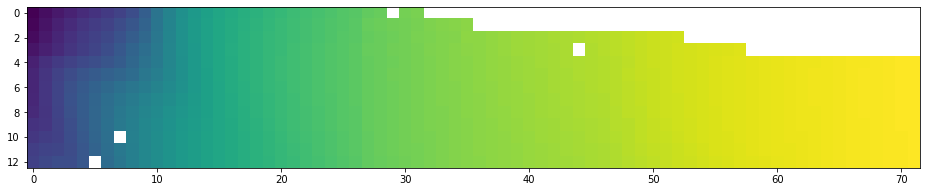

In [5]:
plt.figure(figsize=(16,6))
im = plt.imshow(ints[:,:,6,-1,0].T)

### Digression: assessing non-linearity of the grid

Now let us evaluate the non-linearity of the grid and see if there is a sequence of axes for interpolation that works best. We will go across the entire grid in points where all vertices are defined, estimate the central vertex and compare it to its actual value. That will give us an idea of how significant the sequence of axes is. We do that only for the $\mu=1$ values because that is where intensities are the largest.

In [6]:
# reduced axes/grid:
raxes = axes[:-1]
rgrid = ints[...,-1,:]

nonnantable = np.argwhere(~np.isnan(rgrid[...,0]))

fvs = []

for k, entry in enumerate(nonnantable):
    subgrid = rgrid[max(0,entry[0]-1):min(entry[0]+2,len(axes[0])),
                    max(0,entry[1]-1):min(entry[1]+2,len(axes[1])),
                    max(0,entry[2]-1):min(entry[2]+2,len(axes[2]))]
    if len(subgrid.flatten()) < 27 or np.isnan(subgrid).sum() > 0:
        continue
#     print('subgrid size: %5d; nans: %d; entry: %s' % (len(subgrid.flatten()), np.isnan(subgrid).sum(), entry))
    interps = interpolate_all_directions(entry=entry, axes=raxes, grid=rgrid).flatten()
    fvs.append( 100*(interps-rgrid[tuple(entry)][0])/interps )
fvs = np.array(fvs)
mean_fvs = np.array([fvs[:,0], fvs[:,1:4].mean(axis=1), fvs[:,4:].mean(axis=1)]).T

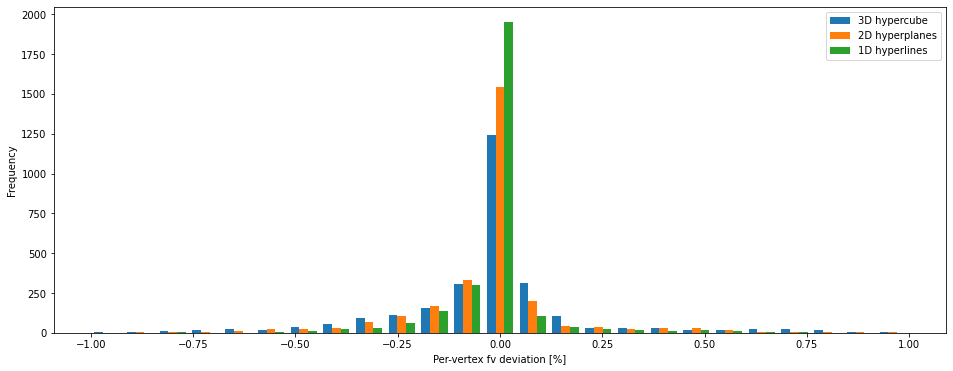

In [7]:
plt.figure(figsize=(16,6))
plt.xlabel('Per-vertex fv deviation [%]')
plt.ylabel('Frequency')
bins = np.linspace(-1., 1., 26)
_ = plt.hist(mean_fvs, bins=bins, label=['3D hypercube', '2D hyperplanes', '1D hyperlines'])
_ = plt.legend()

In terms of numbers:

In [8]:
dirs = ['teff-logg-abun', 'logg-abun', 'teff-abun', 'teff-logg', 'abun', 'teff', 'logg']
for d, m, s in zip(dirs, fvs.mean(axis=0), fvs.std(axis=0)):
    print('direction %14s: %f +/- %f' % (d, m, s))

direction teff-logg-abun: -0.017553 +/- 0.270057
direction      logg-abun: -0.026032 +/- 0.244430
direction      teff-abun: -0.006115 +/- 0.249422
direction      teff-logg: -0.023117 +/- 0.149855
direction           abun: -0.023648 +/- 0.229796
direction           teff: -0.012622 +/- 0.088109
direction           logg: -0.011088 +/- 0.124707


We note that *all* means are negative, which implies a consistent curvature -- the parameter hyperspace is convex and the estimated value will, on average, be underestimated by ~0.02%. In the figure above we see that the deviation tails are quite long, but they taper off almost completely around $\pm 1\%$. The smallest deviation across-the-board is along effective temperature in 1D. The bottom line, though, is that 1% deviation is rarely ever exceeded, and the actual interpolation acts on a cell that is 1/9-th of the cells used here, which makes any inaccuracy due to non-linearity or choice in the axis sequence inconsequential for all practical purposes.

### Digression: time dependence for interpolation

The interpolation *modifies* the input array of function values, `fv`, to achieve its optimal performance. Because of that, we need to copy the input array as we need to reuse it going forward. We can do that either by passing `copy_data=True` to the interpolator, or by copying the array explicitly before passing it on to the interpolator. It is not obvious which is more meritorious in terms of time cost, so let's check:

In [9]:
# x = np.array( ((5772, 4.43, 0.02), (5772, 4.43, 0.02)) )
x = np.array( (5772, 4.43, 0.02) )
lo = np.array((axes[0][9], axes[1][8], axes[2][5]))
hi = np.array((axes[0][10], axes[1][9], axes[2][6]))
fv = ints[9:11,8:10,5:7,-1].reshape(-1, 1)
print('time cost with copying fv by the interpolator:')
%timeit ndpolate(x, lo, hi, fv, copy_data=True)

print('time cost without copying fv by the interpolator:')
fv = ints[9:11,8:10,5:7,-1].copy().reshape(-1, 1)
%timeit ndpolate(x, lo, hi, fv, copy_data=False)

time cost with copying fv by the interpolator:
119 µs ± 6.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
time cost without copying fv by the interpolator:
117 µs ± 18.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


It turns out that the two approaches are equivalent in terms of execution time, so it makes sense to go with the simpler, first option.

### Imputing PHOENIX model atmospheres

The logic behind imputing has been explained in detail above, so we jump right to it here. We will first find all NaN occurrences in the grid, and run the interpolator in all directions for each NaN occurrence. By design, *all* values of $\mu$ will be defined if the combination of $T_\mathrm{eff}$, $\log g$ and $[M/H]$ is defined, so we can impute per $\mu$ instead in the full 4-D space. That pays to do because of the time cost:

In [10]:
import time
start = time.perf_counter()
nantable = np.argwhere(np.isnan(ints[...,0]))
for entry in nantable:
#     subgrid = ints[max(0,entry[0]-1):min(entry[0]+2,len(axes[0])),max(0,entry[1]-1):min(entry[1]+2,len(axes[1])),max(0,entry[2]-1):min(entry[2]+2,len(axes[2]))]
#     print('subgrid size: %5d; nans: %d; entry: %s' % (len(subgrid.flatten()), np.isnan(subgrid).sum(), entry))
    interps = interpolate_all_directions(entry=entry, axes=axes, grid=ints)
    if np.all(np.isnan(interps)):
        continue
    interps = interps[~np.isnan(interps)].mean()
    if not np.isnan(interps):
        ints[tuple(entry)][0] = interps
end = time.perf_counter()
print(f'It took {end-start:2.2f} seconds to impute the grid in 4-D space.')

It took 64.62 seconds to impute the grid in 4-D space.


In [11]:
import time
start = time.perf_counter()
for i in range(len(axes[-1])): # loop over all mus
    subgrid = ints[...,i,:]
    nantable = np.argwhere(np.isnan(subgrid[...,0]))
    for entry in nantable:
        interps = interpolate_all_directions(entry=entry, axes=axes[:-1], grid=subgrid)
        if np.all(np.isnan(interps)):
            continue
        interps = interps[~np.isnan(interps)].mean()
        if not np.isnan(interps):
            subgrid[tuple(entry)][0] = interps
end = time.perf_counter()
print(f'It took {end-start:2.2f} seconds to impute the grid in the reduced 3-D space.')

It took 21.42 seconds to impute the grid in the reduced 3-D space.


Replot to see if imputation looks good:

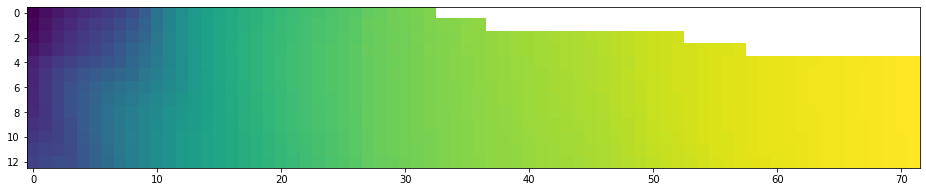

In [12]:
plt.figure(figsize=(16,6))
im = plt.imshow(pb._phoenix_Imu_energy_grid[:,:,6,-1,0].T)

### Blending

The two well defined regimes for computing emergent passband intensities are (1) when the atmospheric parameters fall within the model atmosphere grid, and (2) when the atmospheric parameters fall well outside the model atmosphere grid. In the first case we linearly interpolate (in $N$ dimensions) on the grid, and in the second case we assume a blackbody model atmosphere.

In the latter case we have to deal with one additional complication: limb darkening. Blackbody radiation, by virtue of emergent angle invariance, is not limb-darkened, while stars of course are. That is why the normal emergent passband intensity at a given temperature $T_\mathrm{eff}$ has to be corrected by the integrated limb darkening:

$$ \mathcal L_\mathrm{int} = \int_0^1 \mathcal L(\mu) d\mu, $$

where $\mathcal L(\mu)$ is the limb darkening function and $\mu \equiv \cos \theta$ is the emergent angle. The normal emergent blackbody intensity is then:

$$ B_\mathrm{norm}(\lambda) \mapsto \frac{B_\mathrm{norm}(\lambda)}{\mathcal{L}_\mathrm{int}}. $$

The problem lies in the dependence of $\mathcal L_\mathrm{int}$ on temperature by way of limb darkening coefficients for the given $\mathcal L(\mu)$. When atmospheric parameters are on-grid, $\mathcal L_\mathrm{int}$ is easy to interpolate, but when they are off-grid, $\mathcal L_\mathrm{int}$ needs to be extrapolated. In the vicinity of the grid an $N$-D extrapolation is likely acceptable, but farther from the grid the extrapolated value becomes increasingly unreliable and we are likely better off adopting the _nearest_ value of $\mathcal L_\mathrm{int}$ on the grid instead.

When the values of atmospheric parameters are off the grid but _close_, neither of the above regimes is applicable. If we assumed blackbody radiation, we would introduce a discontinuous jump in emergent passband intensity every time we wander off the grid, which is of course not desired. Instead, this region should "blend" the model atmosphere grid into the blackbody regime as smoothly as possible. Achieving that is our next goal.

It is worth noting that, while blending provides a smooth transition between model atmospheres and blackbody approximation, it does little to nothing to aid in the proper description of physical circumstances that govern this off-grid regime. It is certainly better than a discrete jump, the ultimate solution will be to retire the blackbody approximation and replace it with a more physical model such as the gray atmosphere. Blending will then also be more physical, at least in the sense that the underlying model is not so fundamentally discrepant.

### Blending region

Model atmosphere axes in general follow physical units, so it is impractical to define the blending region in relative terms; for example, 1% in temperature might relate to 500K while 1% in $\log g$ would be 0.05 dex. To rectify that, we remap the axes so that the blending region can be controlled by a single parameter (i.e., the extent beyond the grid boundary). Given the blending region (for example 750K in temperature, 0.5 in surface gravity and 0.5 in abundances), the axes will be rescaled so that the blending region corresponds to 1 unit along each axis. The offsets in the function below are the values of the first element in each axis.

In [13]:
def remap(v, blending_region, offsets):
    return tuple([1/blending_region[k]*(v[k]-offsets[k]) for k in range(len(blending_region))])

Let's now define the blending region and transform the axes:

In [14]:
blending_region = (750., 0.5, 0.5)
offsets = [a[0] for a in raxes]
naxes = remap(raxes, blending_region=blending_region, offsets=offsets)

### The blending function

The smoothness of the on-grid to off-grid transition will depend on several factors:

* similarity of the model atmosphere intensities and blackbody intensities at the edge;
* reliability of the $\mathcal L_\mathrm{int}$ extrapolation (be it actual extrapolation or nearest neighbor value adoption);
* reliability of the model atmosphere intensity extrapolation; and
* the choice of the blending function and its extent (i.e., how fast will extrapolated model atmosphere values be tapered into the blackbody regime).

The first three factors are largely out of our control; the last factor, on the other hand, is. The principal parameter that determines blending is _distance from the grid_; given a vector of interest $\mathbf v$ and distance $d$, the blending function provides a prescription on how to mix the extrapolated grid intensity and blackbody intensity at point $\mathbf v$:

$$ I_\mathrm{blend} (\mathbf v) = \alpha(d) \, I_\mathrm{atm} (\mathbf v) + [1 - \alpha(d)] \, I_\mathrm{bb} (\mathrm{v}), $$

where $\alpha(d)$ is the mixing parameter. The simplest prescription for $\alpha(d)$ might be a simple linear ramp:

$$ \alpha (d) = 1 - \tau d, $$

where $\tau$ controls the slope. A slightly more complicated prescription is a sigmoid ramp:

$$ \alpha (d) = 1 - \left( 1 + e^{-\tau (d-\delta)} \right)^{-1}, $$

where $\tau$ and $\delta$ control sigmoid steepness and offset, respectively.

It is important to note that there is _nothing fundamenally physical_ about the choice of the blending function: we _know_ that blackbody intensities are a poor approximation for stars, and we _know_ that model atmosphere validity deteriorates towards the edge of the definition range; how we blend the two values that we _know_ are wrong is of little practical consequence, for as long as the transition is smooth and the model does not feature a significant number of blended surface elements. Blending is meant only and exclusively to enable us to use model atmospheres for the majority of the star when a handful of surface elements' atmospheric parameters fall off the grid, such as the nose of a semi-detached binary, or a spike in reflection, or close-to-critically spinning stars.

Below we define a blending function with these two choices (linear and sigmoid).

In [15]:
def bf(d, func='sigmoid', tau=15, offset=0.5):
    rv = np.zeros_like(d)
    if func == 'linear':
        rv[d<=1] = 1-d[d<=1]
    elif func == 'sigmoid':
        rv[d<=1] = 1-(1+np.exp(-tau*(d[d<=1]-offset)))**-1
    else:
        print('function `%s` not supported.' % func)
        return None
    rv[d<0] = 1
    return rv

Let's plot a few examples to demonstrate the effect of parameters $\tau$ and $\delta$:

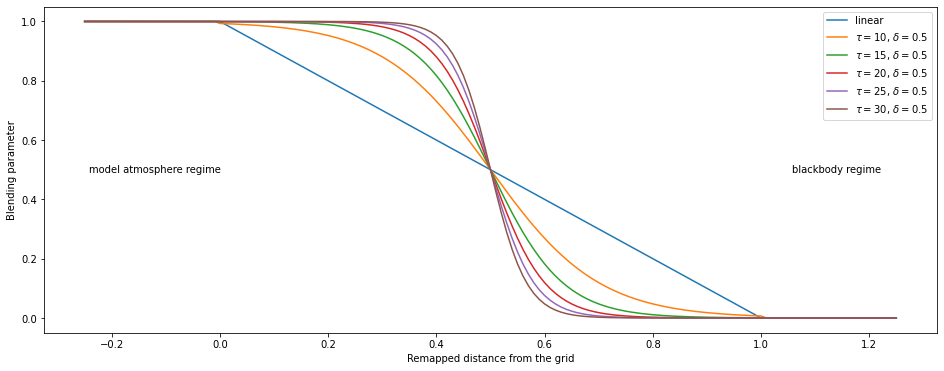

In [16]:
plt.figure(figsize=(16,6))
ds = np.linspace(-0.25, 1.25, 151)
plt.xlabel('Remapped distance from the grid')
plt.ylabel('Blending parameter')
plt.plot(ds, bf(ds, func='linear'), label=r'linear')
for tau in range(10, 31, 5):
    plt.plot(ds, bf(ds, func='sigmoid', tau=tau, offset=0.5), label=r'$\tau=%d,\,\delta=0.5$' % tau)
plt.text(-0.12, 0.5, 'model atmosphere regime', ha='center', va='center')
plt.text(1.14, 0.5, 'blackbody regime', ha='center', va='center')
_ = plt.legend()

### Extrapolate from the grid or adopt the value from the nearest neighbor?

As mentioned above, extrapolation becomes progressively more inaccurate as the distance from the grid increases. In those cases it is likely better to adopt the nearest neighbor value: while demonstrably incorrect, it is almost certainly *less* incorrect than unbound extrapolation. Thus, we need to work out a fast and efficient lookup of the nearest neighbor value.

To that end we employ [k-D trees](https://en.wikipedia.org/wiki/K-d_tree). The algorithm is implemented in scipy; it partitions the data in a way that allows a binary search for the nearest neighbor. To create the search tree, we first identify all non-null vertices and then initialize the tree.

In [17]:
def kdtree(axes, atm_grid):
    non_nan_indices = np.argwhere(~np.isnan(atm_grid))
    non_nan_vertices = np.array([ [axes[i][non_nan_indices[k][i]] for i in range(len(axes))] for k in range(len(non_nan_indices))])
    return spatial.KDTree(non_nan_vertices), non_nan_indices

Querying the tree returns the distance and the index of the nearest neighbor in the non-null array:

In [18]:
ldint_grid = pb._phoenix_ldint_energy_grid
tree, indices = kdtree(naxes, ldint_grid)
d, i = tree.query(remap((3250, 4.2, 0.09), blending_region=blending_region, offsets=offsets))
print('nearest neighbor ldint value: %f' % (ldint_grid[tuple(indices[i])]))

nearest neighbor ldint value: 0.761866


### Computing the blended intensity

Blended emergent intensity can in general be written as:

$$ I_\mathrm{blend} (\mathbf v) = 
\begin{cases}
I_\mathrm{atm} (\mathbf v) & \textrm{model atmosphere region} \\
\alpha I_\mathrm{atm} (\mathbf v) + (1-\alpha) I_\mathrm{bb} (\mathbf v) & \textrm{blending region} \\
I_\mathrm{bb} (\mathbf v) & \textrm{blackbody region} \\
\end{cases} $$

Once we have the blending region and the blending function defined, we can proceed with blending itself. The overall sequence of steps for blending is:

* remap the vector of interest, $\mathbf v$, to the uniform axes;
* among all hypercubes on the grid, find those that are fully defined (i.e., all corresponding intensities are defined and finite) and adjacent to $\mathbf v$;
* for each hypercube:
  * extrapolate the value of $\mathcal L_\mathrm{int}$;
  * calculate blackbody intensity as $I_\mathrm{bb}(\mathrm v) = B(T_\mathrm{eff})/\mathcal L_\mathrm{int}$;
  * extrapolate the value of $I_\mathrm{atm} (\mathbf v)$;
  * calculate the distance vector $\mathbf d$ from $\mathbf v$ to the nearest vertex of the hypercube;
  * project the distance vector onto the normal to the nearest grid surface and calculate $d = \mathbf d \cdot \mathbf {\hat n}$;
  * calculate:
    $$
    I_\mathrm{blend}(\mathbf v) = \begin{cases} I_\mathrm{atm} (\mathbf v) & \textrm{ for } d<0; \\ \alpha I_\mathrm{atm}(\mathbf v) + (1-\alpha) I_\mathrm{bb}(\mathbf v) & \textrm{ for } 0 \leq d \leq 1; \\ I_\mathrm{bb}(\mathbf v) & \textrm{ for } d > 1. \\ \end{cases}
    $$
    Here $\alpha(d)$ is the blending parameter defined above.
* average all $I_\mathrm{blend}(\mathbf v)$ from all hypercubes.

For compute time efficiency, it proves useful to assemble an array of inferior corners of fully defined hypercubes across the entire grid ahead of time; we will use this array to lookup the nearest fully defined hypercube (or a set of hypercubes) for each vector that is off-grid.

In [19]:
ics = np.array([(i, j, k) for i in range(0,len(raxes[0])-1) for j in range(0,len(raxes[1])-1) for k in range(0,len(raxes[2])-1) if ~np.any(np.isnan(ints[i:i+2,j:j+2,k:k+2]))])
print('%d inferior corners of fully defined hypercubes found.' % (len(ics)))

5911 inferior corners of fully defined hypercubes found.


Finally, define blending. The function takes the vector of interest `v`, remapped axes `naxes`, the atmosphere grid `atm_grid`, the integrated limb darkening grid `ldint_grid`, $\mathcal L_\mathrm{int}$ extrapolation mode `ldint_mode`, which can be `extrapolate` or `nearest`, and an optional debugging flag `debug` that cranks up verbosity. The logic of the function follows the prescription above. A few remarks:

* the function calculates $\log I$ instead of $I$ under the hood;
* hypercubes are uniquely identified by their inferior corner: the corner in the hypercube at the lowermost values of axes;
* hypercube shift w.r.t. the hypercube containing $\mathbf v$ is used as a proxy for $\mathbf{\hat n}$ (and, by extension, for $\mathbf{d} \cdot \mathbf{\hat n}$).

In [20]:
def blend(v, naxes, atm_grid, ldint_grid, ldint_mode='interpolate', debug=False):
    nv = remap(v, blending_region=blending_region, offsets=offsets)
    if debug:
        print('vector:', v, '\nnormalized vector:', nv)
    
    # coordinates of the inferior corner:
    entry = [np.searchsorted(naxes[k], nv[k])-1 for k in range(len(naxes))]
    if debug:
        print('coordinates of the inferior corner:', entry)

    # get the inferior corners of all nearest fully defined hypercubes; this
    # is all integer math so we can compare with == instead of np.isclose().
    sep = (np.abs(ics-np.array(entry))).sum(axis=1)
    corners = np.argwhere(sep == sep.min()).flatten()
    if debug:
        print('%d fully defined adjacent hypercube(s) found.' % len(corners))
        for i, corner in enumerate(corners):
            print('  hypercube %d inferior corner: %s' % (i, ics[corner]))

    blints = []
    for corner in corners:
        slc = tuple([slice(ics[corner][k], ics[corner][k]+2) for k in range(len(ics[corner]))])
        if debug:
            print('  nearest fully defined hypercube:', slc)

        # find distance vector to the nearest vertex:
        coords = [naxes[k][slc[k]] for k in range(len(naxes))]
        verts = np.array([(x,y,z) for z in coords[2] for y in coords[1] for x in coords[0]])
        distance_vectors = nv-verts
        distances = (distance_vectors**2).sum(axis=1)
        distance_vector = distance_vectors[distances.argmin()]
        if debug:
            print('  distance vector:', distance_vector)

        shift = entry-ics[corner]
        shift = shift!=0
        if debug:
            print('  hypercube shift: %s' % shift)

        # if the hypercube is unshifted, we're inside the grid; return Inorm().
        if shift.sum() == 0:
            blints.append(np.log10(pb.Inorm(v[0], v[1], v[2], atm='ck2004')[0]))
            continue

        # if the hypercube is adjacent, project the distance vector:
        if shift.sum() == 1:
            distance_vector *= shift
            if debug:
                print('  projected distance vector: %s' % distance_vector)

        distance = np.sqrt((distance_vector**2).sum())

        # At this point we need to decide if we are extrapolating ldint or adopting it from the nearest neighbor.
        # The implementation below is for extrapolation, but both must be supported.

        # extrapolate ldint:
        subgrid = ldint_grid[slc]
        lo = [c[0] for c in coords]
        hi = [c[1] for c in coords]
        fv = subgrid.T.copy().reshape(2**len(naxes))
        if debug:
            print('  lo:', lo)
            print('  hi:', hi)
            print('  fv:', fv)
            # print(subgrid[0,0,0][0], subgrid[1,0,0][0], subgrid[0,1,0][0], subgrid[1,1,0][0], subgrid[0,0,1][0], subgrid[1,0,1][0], subgrid[0,1,1][0], subgrid[1,1,1][0])

        extrapolated_ldint = ndpolate(nv, lo, hi, fv)
        if debug:
            print('  extrapolated ldint value: %f' % extrapolated_ldint)

        bbint = pb._log10_Inorm_bb_energy(v[0]) - np.log10(extrapolated_ldint)

        if distance > 1:
            blints.append(bbint)
            continue

        # extrapolate atm:
        subgrid = atm_grid[slc]
        fv = subgrid.T.reshape(2**len(naxes))
        ckint = ndpolate(nv, lo, hi, fv)
        if debug:
            print('  extrapolated atm value: %f' % ckint)

        # blending:
        alpha = bf(distance)
        if debug:
            print('  orthogonal distance:', distance)
            print('  alpha:', alpha)
        
        blint = (1-alpha)*bbint + alpha*ckint
        if debug:
            print('  blint:', blint)
        blints.append(blint)

    return np.array(blints).mean()

### Application

Let us now explore the effects of blending across several interesting boundaries. Perhaps the most interesting in terms of application is the low temperature boundary. Let's do that for the ck2004 atmospheres.

In [21]:
def log_bb_intensity(v, naxes, ldint_grid, ldint_mode='extrapolate', ldint_tree=None, ldint_indices=None):
    nv = remap(v, blending_region=blending_region, offsets=offsets)
    
    # coordinates of the inferior corner:
    entry = [np.searchsorted(naxes[k], nv[k])-1 for k in range(len(naxes))]

    # get the inferior corners of all nearest fully defined hypercubes; this
    # is all integer math so we can compare with == instead of np.isclose().
    sep = (np.abs(ics-np.array(entry))).sum(axis=1)
    corners = np.argwhere(sep == sep.min()).flatten()

    if ldint_mode == 'nearest':
        if ldint_tree is None or ldint_indices is None:
            return None
        d, i = ldint_tree.query(nv)
        return pb._log10_Inorm_bb_energy(v[0]) - np.log10(ldint_grid[tuple(ldint_indices[i])])
    
    bbints = []
    for corner in corners:
        slc = tuple([slice(ics[corner][k], ics[corner][k]+2) for k in range(len(ics[corner]))])

        # find distance vector to the nearest vertex:
        coords = [naxes[k][slc[k]] for k in range(len(naxes))]

        # At this point we need to decide if we are extrapolating ldint or adopting it from the nearest neighbor.
        # The implementation below is for extrapolation, but both must be supported.

        if ldint_mode == 'extrapolate':
            # extrapolate ldint:
            subgrid = ldint_grid[slc].copy()
            lo = [c[0] for c in coords]
            hi = [c[1] for c in coords]
            fv = subgrid.T.reshape(2**len(naxes))
            extrapolated_ldint = ndpolate(nv, lo, hi, fv)
            bbints.append(pb._log10_Inorm_bb_energy(v[0]) - np.log10(extrapolated_ldint))
        else:
            print('not implemented yet.')
            return None
    
    return np.array(bbints).mean()

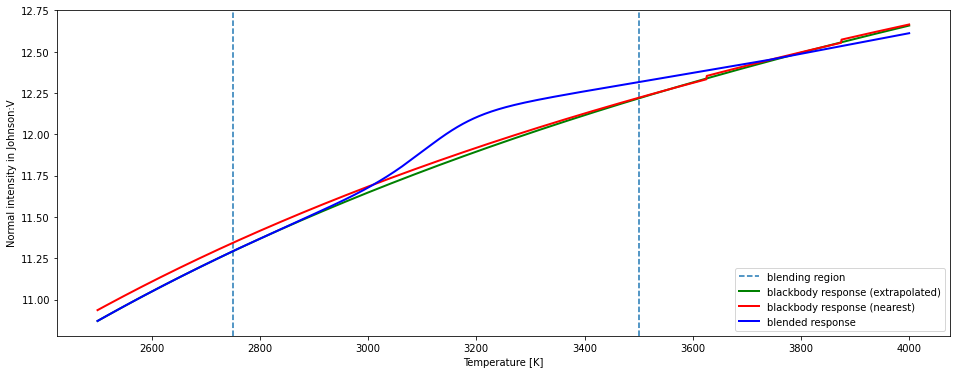

In [22]:
raxes = pb._ck2004_intensity_axes[:-1]
rgrid = pb._ck2004_Imu_energy_grid[...,-1,:]
offsets = [a[0] for a in raxes]
logg, abun = 4.2, 0.09
teffs = np.arange(4000., 2499., -1.)
ints = np.empty_like(teffs)
bbints = np.empty_like(teffs)
bbints_nearest = np.empty_like(teffs)

ldint_grid = pb._ck2004_ldint_energy_grid

naxes = remap(raxes, blending_region=blending_region, offsets=offsets)

# initialize the nearest-neighbor search:
ldint_tree, ldint_indices = kdtree(naxes, ldint_grid)

for i, teff in enumerate(teffs):
    ints[i] = blend((teff, logg, abun), naxes, rgrid, ldint_grid)
    bbints[i] = log_bb_intensity((teff, logg, abun), naxes, ldint_grid, 'extrapolate')
    bbints_nearest[i] = log_bb_intensity((teff, logg, abun), naxes, ldint_grid, 'nearest', ldint_tree=ldint_tree, ldint_indices=ldint_indices)

plt.figure(figsize=(16,6))
plt.xlabel('Temperature [K]')
plt.ylabel('Normal intensity in Johnson:V')
plt.gca().axvline(3500, ls='--')
plt.gca().axvline(3500-blending_region[0], ls='--', label='blending region')
plt.plot(teffs, bbints, 'g-', lw=2, label='blackbody response (extrapolated)')
plt.plot(teffs, bbints_nearest, 'r-', lw=2, label='blackbody response (nearest)')
plt.plot(teffs, ints, 'b-', lw=2, label='blended response')
_ = plt.legend(loc='lower right')
